In [13]:
from sklearn.model_selection import train_test_split
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.autonotebook import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

In [14]:
rna_df = feather.read_feather("shared_data/rna_df.feather")
sample_info = pd.read_csv("shared_data/cancer.samples", sep="\t")[
    ["sample", "project_descriptor", "sample_type"]
]
expression_df = (
    pd.read_feather("shared_data/expression_df.feather")
    .drop(["key"], axis=1)
    .transpose()
)
methylation_data_df = (
    pd.read_feather("shared_data/methylation_data_df.feather")
    .drop(["PMR_INDEX"], axis=1)
    .transpose()
)
sample_info = sample_info.set_index("sample")

In [15]:
input_data_df = expression_df.join(sample_info, how="inner")

# One-hot encode categorical variables
project_descriptor_encoded = pd.get_dummies(
    input_data_df["project_descriptor"], prefix="cancer_type"
)
sample_type_encoded = pd.get_dummies(input_data_df["sample_type"], prefix="sample_type")
data_df = pd.concat(
    [
        input_data_df.drop(["project_descriptor", "sample_type"], axis=1),
        project_descriptor_encoded,
        sample_type_encoded,
    ],
    axis=1,
)

# Scale Data
scaler = StandardScaler()
expression_scaled = scaler.fit_transform(data_df.values.astype(np.float64))
expression_data = expression_scaled
meth_data =methylation_data_df.values.astype(np.float64)/ 100
expression_data = np.hstack(
    [np.ones((expression_data.shape[0], 1)).astype(np.float64), expression_data]
)
expression_data = expression_data

In [16]:
expression_data.shape

(2586, 60690)

In [17]:
methylation_data_df.shape

(2586, 98)

In [18]:
rna_df

,key,name,type
0,ENSG00000000003.15,TSPAN6,protein_coding
1,ENSG00000000005.6,TNMD,protein_coding
2,ENSG00000000419.13,DPM1,protein_coding
3,ENSG00000000457.14,SCYL3,protein_coding
4,ENSG00000000460.17,C1orf112,protein_coding
...,...,...,...
60655,ENSG00000288669.1,AC008763.4,protein_coding
60656,ENSG00000288670.1,AL592295.6,lncRNA
60657,ENSG00000288671.1,AC006486.3,protein_coding
60658,ENSG00000288674.1,AL391628.1,protein_coding


In [19]:
expression_data_train, expression_data_test, meth_data_train, meth_data_test = (
    train_test_split(expression_data, meth_data, test_size=0.33, random_state=42)
)

In [20]:
regr = RandomForestRegressor(random_state=0)
regr.fit(expression_data_train, meth_data_train)

RandomForestRegressor(random_state=0)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

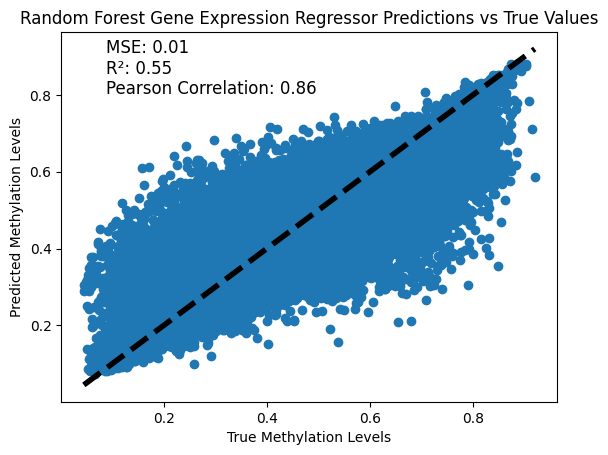

In [22]:
x_test_data = expression_data_test
y_test_data = meth_data_test
y_pred = regr.predict(x_test_data)
mse = mean_squared_error(y_test_data, y_pred)
r2 = r2_score(y_test_data, y_pred)
pearson_corr, _ = pearsonr(y_test_data.flatten(), y_pred.flatten())

# Plot the Results
plt.scatter(y_test_data, y_pred)
plt.xlabel("True Methylation Levels")
plt.ylabel("Predicted Methylation Levels")
plt.title("Random Forest Gene Expression Regressor Predictions vs True Values")
plt.plot(
    [y_test_data.min(), y_test_data.max()],
    [y_test_data.min(), y_test_data.max()],
    "k--",
    lw=4,
)

x_text = y_test_data.min() + (y_test_data.max() - y_test_data.min()) * 0.05
y_text = y_pred.min() + (y_pred.max() - y_pred.min()) * 0.9

plt.text(
    x_text,
    y_text,
    f"MSE: {mse:.2f}\nR²: {r2:.2f}\nPearson Correlation: {pearson_corr:.2f}",
    fontsize=12,
)

plt.show()